## CNN to distinguish cats, dogs, woves and plants
In this notebook we will perform image classification with a convolutional neural network. We will use a dataset of photos of 3 animals (tabby cats, German shepherds and grey woves) and plants seedlings of 9 plant species. The animal photos were downloaded from [IMAGENET](http://www.image-net.org/). The plant dataset is an excerpt from https://www.kaggle.com/vbookshelf/a-simple-keras-solution. All input images are in subfolders of ```data/cats-dogs-plants``` respective to their class.

What you will learn: 
 - convolutional layers (Conv2D)
 - handling of image datasets (```tf.data.Dataset```)
 - image augmentation
 - monitoring training progress (callbacks)
 - saving and reading a model to and from a file
 - classification error analysis

In [1]:
import random
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
import pandas as pd
import pandas.util
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import math

## Image Data Preparation - Make Data Frames
We will create Pandas data frames to hold the file names and class labels. These data structures are small as they do not contain the actual image data. The images are on the drive and never are they all loaded to memory, so this approach scales to very large training sets of images.

In [2]:
# directory with image class subdirectories
img_path = '../data/cats-dogs-plants'

# Create a pandas dataframe from a tab separated file 
df = pd.read_csv(img_path + "/classes-and-fnames.txt", sep = '\t', names = ['classname', 'fname'])
df['path'] = img_path + '/' + df['classname'] + "/" + df['fname']

print(df.head())
print("shape of data frame: ", df.shape)

  classname     fname                                            path
0       cat  1000.png  ../KI-Block/data/cats-dogs-plants/cat/1000.png
1       cat  1001.png  ../KI-Block/data/cats-dogs-plants/cat/1001.png
2       cat  1002.png  ../KI-Block/data/cats-dogs-plants/cat/1002.png
3       cat  1003.png  ../KI-Block/data/cats-dogs-plants/cat/1003.png
4       cat  1005.png  ../KI-Block/data/cats-dogs-plants/cat/1005.png
shape of data frame:  (7454, 3)


In [3]:
# associate class names with a class (0 .. K-1)
classnames = df['classname'].unique() # all 12 species names
K = classnames.size  # 12
name2class = dict(zip(classnames, range(K))) # dictionary that maps a name to its index in classnames array
print("names and classes:", name2class)

# Add a column 'class' to data frame  with the number representing the species name
df['class'] = df['classname'].map(name2class) # new column class with number representing plant name

# print a few random example lines
print(df.sample(n=5))

names and classes: {'cat': 0, 'shepherd': 1, 'wolf': 2, 'CommonWheat': 3, 'Maize': 4, 'Small-floweredCranesbill': 5, 'Charlock': 6, 'FatHen': 7, 'ScentlessMayweed': 8, 'SugarBeet': 9, 'CommonChickweed': 10, 'LooseSilky-bent': 11}
            classname    fname  \
1951         shepherd  925.png   
6959  LooseSilky-bent  356.png   
2661             wolf   66.png   
1321         shepherd  352.png   
3237            Maize  237.png   

                                                   path  class  
1951  ../KI-Block/data/cats-dogs-plants/shepherd/925...      1  
6959  ../KI-Block/data/cats-dogs-plants/LooseSilky-b...     11  
2661      ../KI-Block/data/cats-dogs-plants/wolf/66.png      2  
1321  ../KI-Block/data/cats-dogs-plants/shepherd/352...      1  
3237    ../KI-Block/data/cats-dogs-plants/Maize/237.png      4  


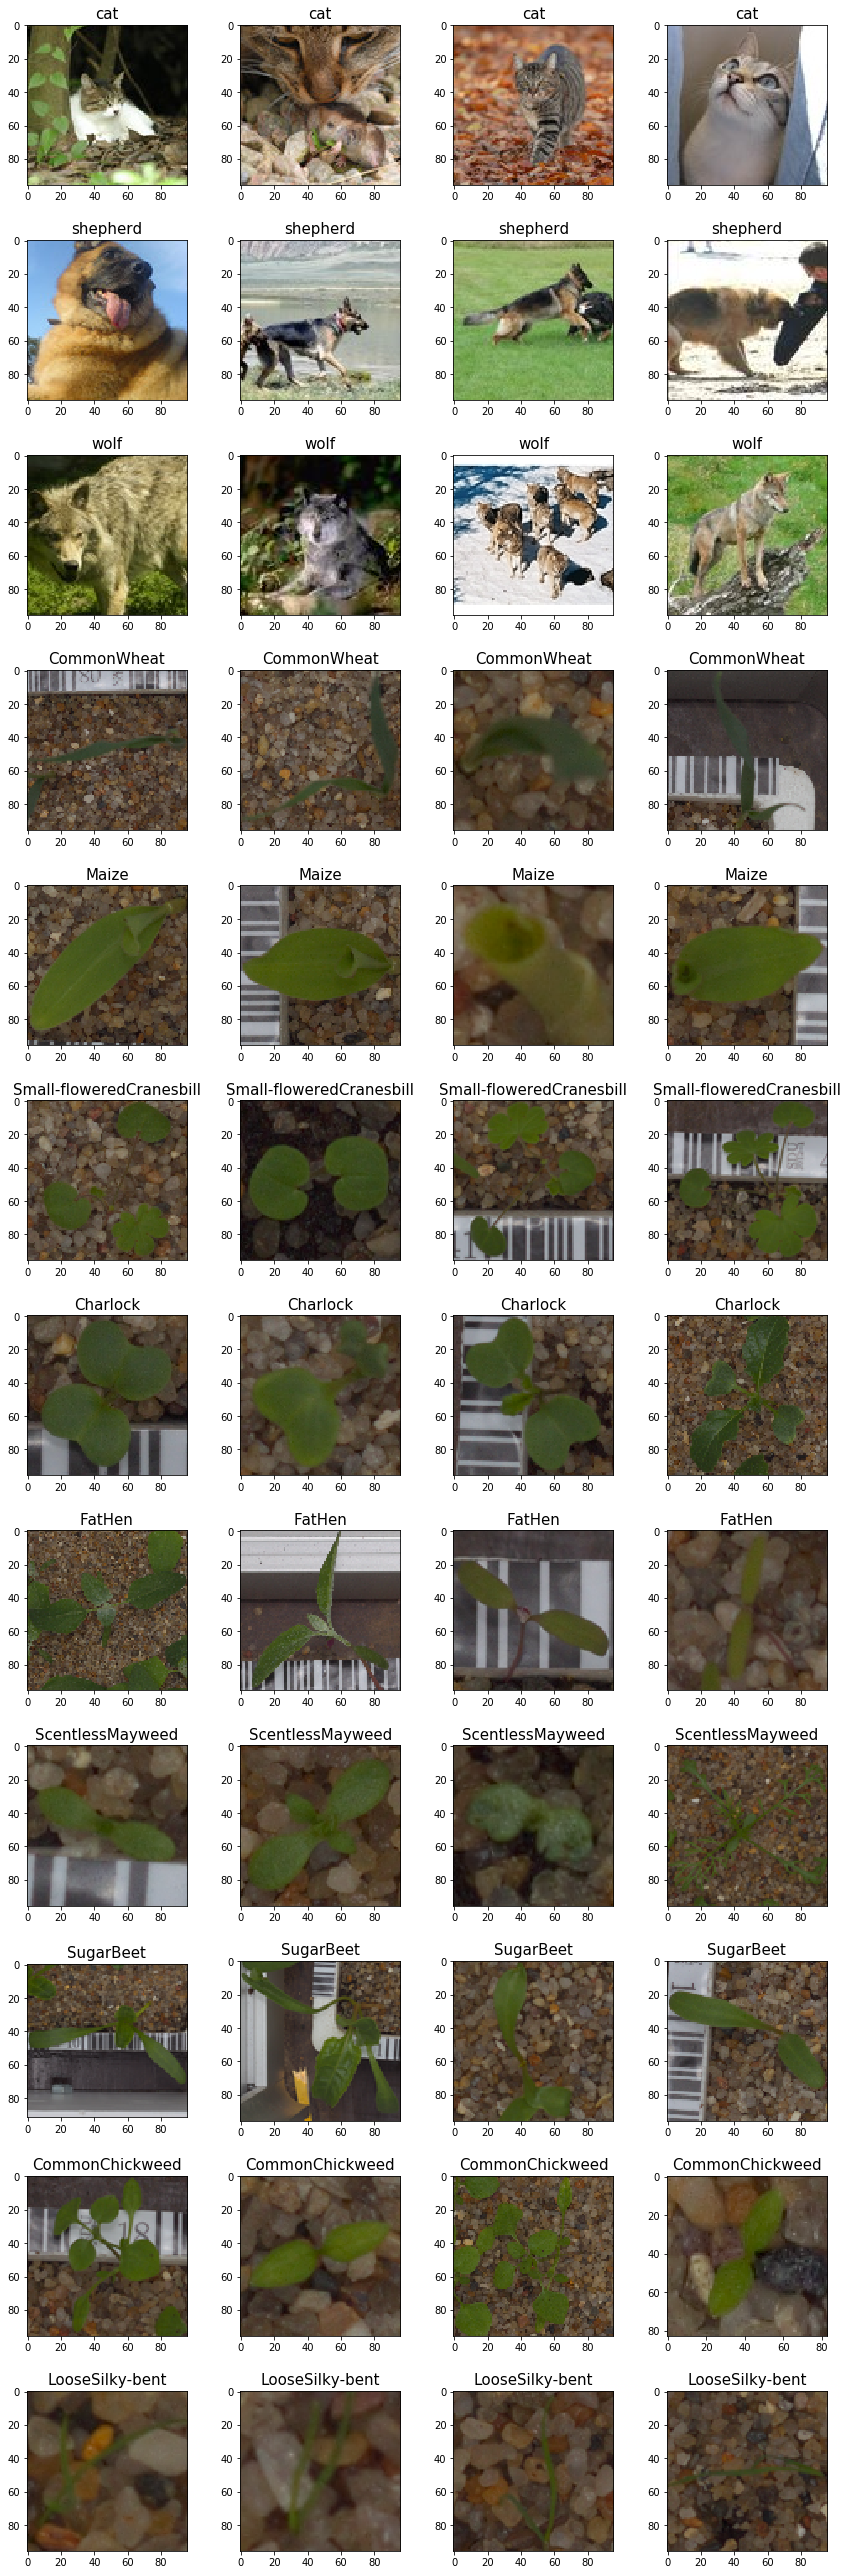

In [4]:
# Plot a few sample images for each class
examples_per_class = 4
_, ax = plt.subplots(nrows = K, ncols = examples_per_class, 
                     figsize = (3 * examples_per_class, 3 * K)) # adjust size here
    
for i in range(K): # loop over classes = rows
    sample = df[df['class'] == i].sample(n = examples_per_class)
    for j in range(examples_per_class):
        path = sample.iloc[j]['path']
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 has color order BGR rather than RGB
        ax[i, j].imshow(img)
        ax[i, j].set_title(classnames[i], fontsize=15)  
plt.tight_layout()
plt.show()

In [5]:
num_animals = 3 # assume that the first classes are animals
# percentages for the relative frequencies of each plant
100 * df['classname'].value_counts() / df.shape[0]

cat                         13.683928
shepherd                    13.603434
wolf                        10.719077
LooseSilky-bent             10.222699
CommonChickweed              9.565334
ScentlessMayweed             8.143279
Small-floweredCranesbill     7.727395
FatHen                       7.217601
SugarBeet                    6.211430
Charlock                     6.063858
Maize                        3.447813
CommonWheat                  3.394151
Name: classname, dtype: float64

**Question:** What is the fraction of correct guesses (accuracy) you are expected to get with a good random guessing method, i.e. without even looking at a photo?

### Training, Validation and Test Split

In [6]:
# randomly split data frame into training, validation and test data frames
num_imgs  = df.shape[0] # total number of examples
num_test  = 400 # size of test set, used only once at end
num_val   = 300 # size of validation set, used to monitor training progress
num_train = num_imgs - num_test - num_val # size of training set, the (large) rest

assert num_train > 0, "Error: examples consumed by test and validation sets alone"

# construct an array [0, 1, ..., num_imgs] with the indices = row numbers of df
all_idxs = np.array(range(num_imgs))
np.random.shuffle(all_idxs) # random order, so there is no bias in any partition

# construct training and testing data frames 
test_df = df.iloc[all_idxs[0 : num_test]]
val_df = df.iloc[all_idxs[num_test : num_test + num_val]]
train_df = df.iloc[all_idxs[num_test + num_val :]] # the rest

assert train_df.shape[0] == num_train, "Internal error of 3-way split into train, test, val"
print("Sizes: train =", num_train, "\tvalidation =", num_val, "\ttest =", num_test)

Sizes: train = 6754 	validation = 300 	test = 400


## Make TensorFlow Datasets

In [7]:
img_size = 96    # width and height of all images (resize, if required)
batch_size = 32  # for training and prediction

### Image Augmentation
From one image on the drive one can generate many training examples, e.g.

 - by mirroring and rotating the image where it preserves the label
 - by random cropping followed by resizing
 - by random changes to colors.
    
**Goals:**
 - Have a much larger effective training set (the bigger the better).
 - Make it more robust with respect to biases, e.g. the direction of light during photography may have
    had a systematic bias, say, if maize was on one side of the greenhouse and sugar beets on the other. 

In [8]:
def path_to_array(filename, label):
    """ Map a filename to an actual image tensor using image augmentation, one-hot encode label."""
    img = tf.io.read_file(filename)
    img = tf.image.decode_png(img, channels = 3)
    # now img is 3 dim array of numbers in {0,..., 255}
    img = tf.cast(img, dtype = tf.float32) / 255. # scale to floating point number in [0,1]
    
    # resize to fixed input size
    img = tf.image.resize(img, [img_size, img_size])
    
    # image augmentation, make one of 8 congruent or mirrored images
    img = tf.image.random_flip_left_right(img) # 50% chance to mirror vertically
    num_rot = np.random.randint(0, 4) # rotate 0-3 times counter-clockwise by a 90 degrees  
    img = tf.where(label >= num_animals, # assume that plants photos are bird's-eye view and may be rotated
                   tf.image.rot90(img, k = num_rot),
                   img)

    # randomly change colors
    img = tf.image.random_brightness(img, max_delta = 0.1)
    img = tf.image.random_hue(img, max_delta = 0.02)
    img = tf.image.random_saturation(img, lower = 0.95, upper = 1.05)
    
    # one-hot encode the label, e.g. 3 becomes [0,0,0,1,0,0,0,0,0,0,0,0]
    label = tf.one_hot(label, depth = K)
    return img, label

In [9]:
def make_dataset(df):
    """ Make a tf dataset of images from a pd data frame of file paths """

    # first, make dataset with just the relevant: path and class
    ds_path = tf.data.Dataset.from_tensor_slices((df['path'], df['class']))

    # convert to data set with actual images
    ds = ds_path.map(path_to_array)
    ds = ds.batch(batch_size)
    return ds

test_ds  = make_dataset(test_df)
val_ds   = make_dataset(val_df)
train_ds = make_dataset(train_df)
train_ds = train_ds.repeat() # infinitely repeat

W0918 22:33:22.836421 139824479618880 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


data frame:
 classname                                             shepherd
fname                                                  530.png
path         ../KI-Block/data/cats-dogs-plants/shepherd/530...
class                                                        1
Name: 1516, dtype: object

data set:
x: tf.Tensor(
[[[0.32291192 0.34552264 0.11169036]
  [0.3503629  0.37297362 0.13914134]
  [0.36997074 0.39258146 0.15874918]
  ...
  [0.8474834  0.6717169  0.39212587]
  [0.8317971  0.65638876 0.38464424]
  [0.823954   0.6485457  0.37680113]]

 [[0.3512666  0.35336578 0.11953351]
  [0.36695287 0.36905205 0.1352198 ]
  [0.37871757 0.38081676 0.14698447]
  ...
  [0.87885594 0.7030895  0.4234984 ]
  [0.8710128  0.6956045  0.42385995]
  [0.86709124 0.6916828  0.41993836]]

 [[0.2766986  0.3376795  0.23101914]
  [0.2766986  0.3376795  0.23101914]
  [0.2766986  0.3376795  0.23101914]
  ...
  [0.8945422  0.71877575 0.43918473]
  [0.8827775  0.7116506  0.43972692]
  [0.8866991  0.7155721  0.443648

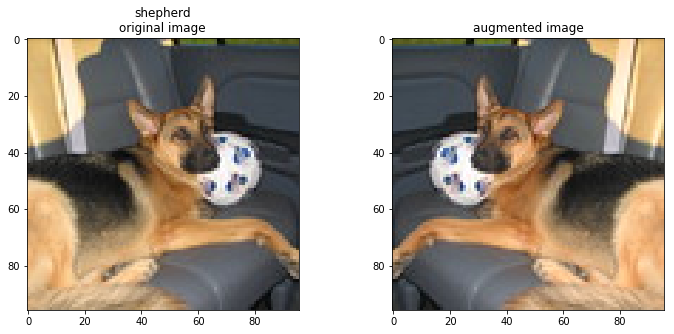

In [10]:
# print and display first example from first batch
for (x, y) in train_ds.take(1):
    print("data frame:\n", train_df.iloc[0])
    print("\ndata set:")
    print("x:", x[0], "\ny: ", y[0])
    _, ax = plt.subplots(ncols = 2, figsize = (12, 5))
    
    # plot original image as on drive
    path = train_df.iloc[0]['path']
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    ax[0].imshow(img)
    ax[0].set_title(classnames[np.argmax(y[0])] + "\noriginal image")
    
    # plot augmented image
    ax[1].imshow(x[0])
    ax[1].set_title("augmented image")

## Define and Train a Convolutional Neural Network
**Layer types:**
 - Conv2D convolutional layer, here inputs are 3dim and the convolution sums over the 3rd dim.
 - MaxPooling2D takes local maxima over a rectangular region.
 - Dropout randomly deactivates neurons during training, which can make training more robust.
 - [BatchNormalization](https://arxiv.org/pdf/1502.03167.pdf), centralizes and scales its input to have approximately 0 mean and variance 1.

Model architecture modified from [this source](https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 96, 96, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        1

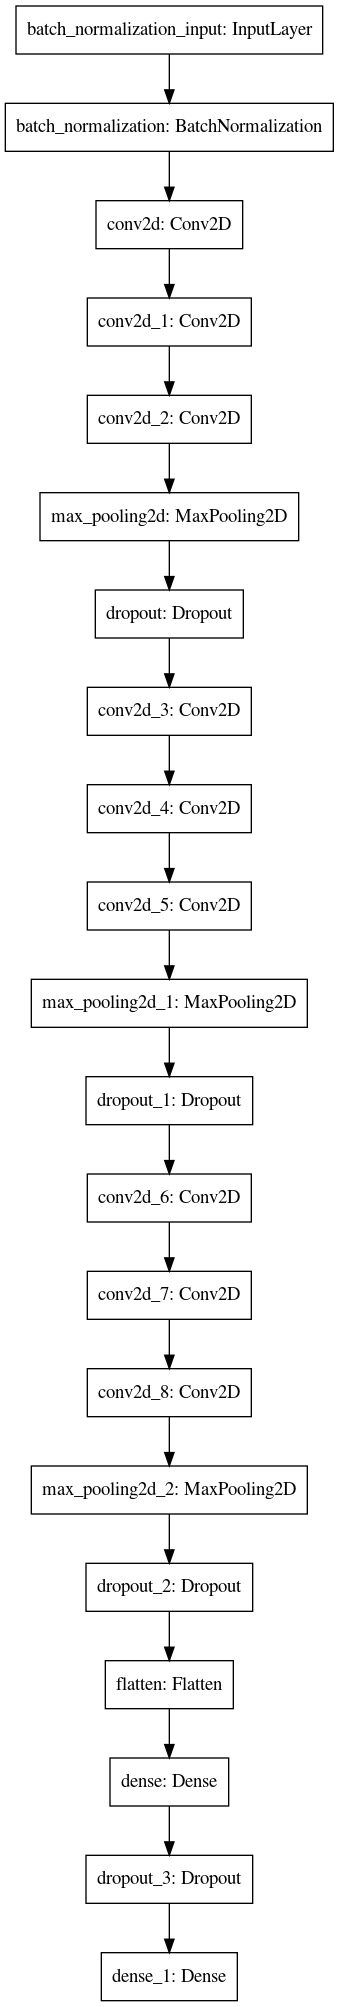

In [11]:
np.random.seed(1) # so we all get the same pseudorandom results

kernel_size = (3, 3)
pool_size   = (2, 2)
first_filters  = 32
second_filters = 64
third_filters  = 128
dropout_conv  = 0.3
dropout_dense = 0.3

model = tf.keras.models.Sequential() # sequential stack of layers

model.add( BatchNormalization(input_shape = (img_size, img_size, 3)))
model.add( Conv2D (first_filters, kernel_size, activation = 'relu'))
model.add( Conv2D (first_filters, kernel_size, activation = 'relu'))
model.add( Conv2D (first_filters, kernel_size, activation = 'relu'))
model.add( MaxPooling2D (pool_size = pool_size)) 
model.add( Dropout (dropout_conv))

model.add( Conv2D (second_filters, kernel_size, activation ='relu'))
model.add( Conv2D (second_filters, kernel_size, activation ='relu'))
model.add( Conv2D (second_filters, kernel_size, activation ='relu'))
model.add( MaxPooling2D (pool_size = pool_size))
model.add( Dropout (dropout_conv))

model.add( Conv2D (third_filters, kernel_size, activation ='relu'))
model.add( Conv2D (third_filters, kernel_size, activation ='relu'))
model.add( Conv2D (third_filters, kernel_size, activation ='relu'))
model.add( MaxPooling2D (pool_size = pool_size))
model.add( Dropout (dropout_conv))

model.add( Flatten())
model.add( Dense (256, activation = "relu", kernel_regularizer = tf.keras.regularizers.l2(0.001)))
model.add( Dropout (dropout_dense))
model.add( Dense (K, activation = "softmax"))

model.summary()
# draw an image with the layers
# tf.keras.utils.plot_model(model)

In [12]:
# define the loss, optimization algorithm and prepare the model for gradient computation 
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
# Callbacks: What should be done during (long) training?
modelfname = "animals_and_plants.h5"
# Function to store model to file, if validation loss has a new record
# Check always after having seen at least another save_freq examples.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    modelfname, monitor = 'val_loss', mode = 'min', 
    save_best_only = True, verbose = 1)

# Function to decrease learning rate by 'factor'
# when there has been no significant improvement in the last 'patience' epochs.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss', mode = 'min', factor = 0.75, patience = 4, verbose = 1)
                         
# fit_generator is like fit, but training set generation (image reading) is run in parallel to optimization
history = model.fit_generator(
    train_ds, epochs = 50, 
    steps_per_epoch = 600, # num_train / batch_size would use each example once on average
    validation_data = val_ds, verbose = 1,
    callbacks = [checkpoint, reduce_lr])

Epoch 1/50


W0918 22:33:23.826421 139824479618880 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/math_grad.py:1394: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


599/600 [============================>.] - ETA: 1s - loss: 1.7025 - accuracy: 0.3816
Epoch 00001: val_loss improved from inf to 1.37138, saving model to animals_and_plants.h5
600/600 [==============================] - 690s 1s/step - loss: 1.7017 - accuracy: 0.3816 - val_loss: 1.3714 - val_accuracy: 0.4667
Epoch 2/50
599/600 [============================>.] - ETA: 1s - loss: 1.1146 - accuracy: 0.5707
Epoch 00002: val_loss improved from 1.37138 to 0.95035, saving model to animals_and_plants.h5
600/600 [==============================] - 660s 1s/step - loss: 1.1149 - accuracy: 0.5706 - val_loss: 0.9504 - val_accuracy: 0.6533
Epoch 3/50
599/600 [============================>.] - ETA: 1s - loss: 0.8954 - accuracy: 0.6645
Epoch 00003: val_loss improved from 0.95035 to 0.82959, saving model to animals_and_plants.h5
600/600 [==============================] - 656s 1s/step - loss: 0.8952 - accuracy: 0.6645 - val_loss: 0.8296 - val_accuracy: 0.7200
Epoch 4/50
599/600 [============================>

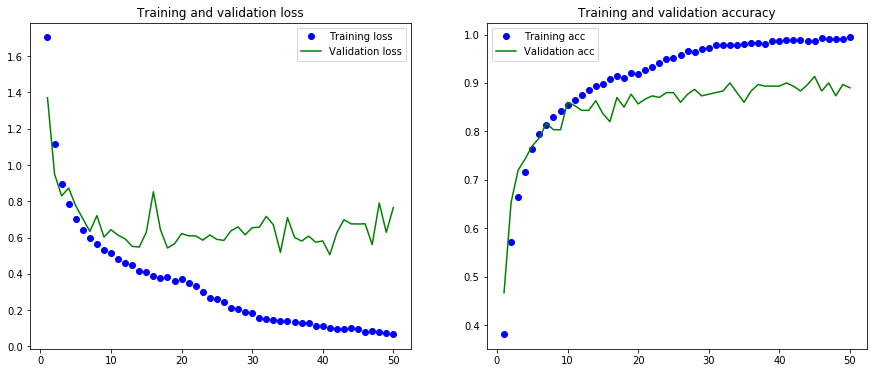

In [14]:
# plot the training history as loss and accuracy curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

_, ax = plt.subplots(ncols = 2, figsize = (15, 6))
ax[0].plot(epochs, loss, 'bo', label = 'Training loss')
ax[0].plot(epochs, val_loss, 'g', label = 'Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].legend()

ax[1].plot(epochs, acc, 'bo', label = 'Training acc')
ax[1].plot(epochs, val_acc, 'g', label = 'Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].legend();

## Evaluation after Training

In [15]:
# Load the parameters with the best validation accuracy during training.
# This works also if you interruped the training!
model.load_weights(modelfname)

test_loss, test_acc = model.evaluate(test_ds, verbose = 0)
print("Loss on test set:", test_loss, "\nAccuracy on test set:", test_acc)

Loss on test set: 0.40689854667736935 
Accuracy on test set: 0.92


In [16]:
# make a prediction
prediction = model.predict(test_ds)
yhat = prediction.argmax(axis = 1)
if 'pred' not in test_df:
    test_df.insert(4, 'pred',  prediction.argmax(axis = 1))
if 'confidence' not in test_df:
    test_df.insert(5, 'confidence',  prediction.max(axis = 1))

print("Predicted probabilities for first 5 examples:\n", np.round(prediction[0:5], 3))
print("Predicted classes for first 5 examples:\n", test_df['pred'][0:5])
print("Probability of prediction:\n", test_df['confidence'][0:5])
test_df.head()

Predicted probabilities for first 5 examples:
 [[0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.434 0.334 0.23  0.    0.    0.    0.    0.    0.    0.    0.001 0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    1.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]
Predicted classes for first 5 examples:
 5812     9
207      0
6832    11
3469     5
2271     2
Name: pred, dtype: int64
Probability of prediction:
 5812    1.000000
207     0.433861
6832    1.000000
3469    1.000000
2271    1.000000
Name: confidence, dtype: float32


,classname,fname,path,class,pred,confidence
5812,SugarBeet,369.png,../KI-Block/data/cats-dogs-plants/SugarBeet/36...,9,9,1.000000
207,cat,266.png,../KI-Block/data/cats-dogs-plants/cat/266.png,0,0,0.433861
6832,LooseSilky-bent,235.png,../KI-Block/data/cats-dogs-plants/LooseSilky-b...,11,11,1.000000
3469,Small-floweredCranesbill,214.png,../KI-Block/data/cats-dogs-plants/Small-flower...,5,5,1.000000
2271,wolf,315.png,../KI-Block/data/cats-dogs-plants/wolf/315.png,2,2,1.000000


In [17]:
confusion_matrix(test_df['class'], test_df['pred'])

array([[37,  7,  3,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 2, 52,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  4, 37,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  1, 12,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 36,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 22,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 18,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  1,  0, 29,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0, 35,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0, 44]])

In [18]:
print(classification_report(test_df['class'], test_df['pred'], target_names = classnames))

                          precision    recall  f1-score   support

                     cat       0.90      0.77      0.83        48
                shepherd       0.83      0.90      0.86        58
                    wolf       0.84      0.84      0.84        44
             CommonWheat       0.83      0.91      0.87        11
                   Maize       0.80      0.92      0.86        13
Small-floweredCranesbill       1.00      1.00      1.00        36
                Charlock       1.00      1.00      1.00        22
                  FatHen       0.95      0.95      0.95        19
        ScentlessMayweed       0.95      1.00      0.97        35
               SugarBeet       1.00      0.91      0.95        32
         CommonChickweed       1.00      0.97      0.99        36
         LooseSilky-bent       0.94      0.96      0.95        46

               micro avg       0.92      0.92      0.92       400
               macro avg       0.92      0.93      0.92       400
        

### Display misclassified photos of animals

In [19]:
# Make data frame of all misclassifications that involve an animal
false_animals_df = test_df[(test_df['class'] != test_df['pred']) # misclassified and
                           & ((test_df['class'] < num_animals) # is an animal
                              | (test_df['pred'] < num_animals))] # or was predicted to be an animal
numfalse = false_animals_df.shape[0]
print("number of misclassifications that involve an animal :", numfalse)

number of misclassifications that involve an animal : 24


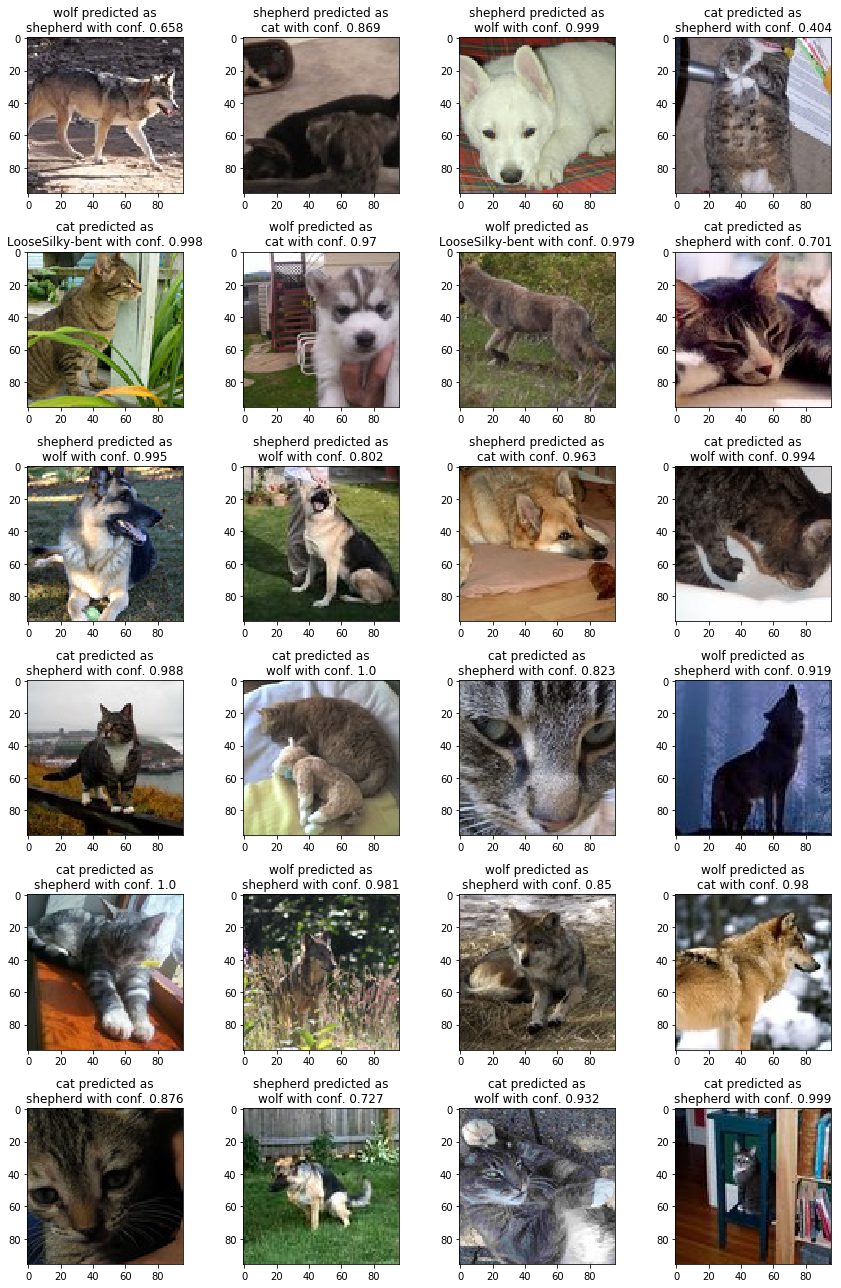

In [20]:
num_show = min(numfalse, 50) # show at most 50 false examples
ncols = 4
nrows = math.ceil(num_show / ncols) # round up
nrows = min(nrows, 15) # at most 15 rows
f, ax = plt.subplots(nrows, ncols, figsize = (3 * ncols, 3 * nrows))
for k in range(num_show):
    i = math.floor(k / ncols) # row
    j = k % ncols # column
    record = false_animals_df.iloc[k]
    path = record['path']
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    ax[i, j].imshow(img)
    ax[i, j].set_title(classnames[record['class']] + " predicted as\n"
                       + str(classnames[record['pred']]) + " with conf. "
                       + str(np.round(record['confidence'], 3)),
                      fontsize=12)

plt.tight_layout()